In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score


# CSV 파일 불러오기
train_data = pd.read_csv("../merged_dataset/single_train/single_train.csv")
valid_data = pd.read_csv("../extracted_keypoints/quickly_valid/jw_type2_11.csv")
test_data = pd.read_csv("../extracted_keypoints/quickly_test/sj_type2_7.csv")


lr = 0.001
eps = 100

In [2]:
# 'Frame'열을 제외한 모든 열 선택
feature_columns = train_data.columns[1:-1]

# 입력 데이터(X)와 레이블(Y) 분리
X_train = train_data[feature_columns].values
Y_train = train_data['Label'].values

X_valid = valid_data[feature_columns].values
Y_valid = valid_data['Label'].values

X_test = test_data[feature_columns].values
Y_test = test_data['Label'].values



# standardscaler로 데이터 정규화
scaler = StandardScaler()



X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)



X_train=X_train.astype(int)
Y_train=Y_train.astype(int)

X_valid=X_valid.astype(int)
Y_valid=Y_valid.astype(int)

X_test=X_test.astype(int)
Y_test=Y_test.astype(int)



In [3]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], 1), return_sequences=True))  # 첫 번째 LSTM 레이어 추가
model.add(Dropout(0.2))  # Dropout 레이어 추가
model.add(LSTM(100))  # 두 번째 LSTM 레이어 추가
model.add(Dropout(0.2))  # Dropout 레이어 추가
model.add(Dense(1, activation='sigmoid'))  # 출력 레이어 추가

In [4]:
# 모델 컴파일
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

In [5]:
# 데이터 형태 조정 (3D로 변환)
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_3d = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [6]:
# 모델 학습
history=model.fit(X_train_3d, Y_train, epochs=eps, validation_data=(X_val_3d, Y_valid))

Epoch 1/100
32/32 [==============================] - 4s 38ms/step - loss: 0.4919 - auc: 0.8474 - val_loss: 0.9276 - val_auc: 0.9599
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.4276 - auc: 0.8811 - val_loss: 0.8808 - val_auc: 0.9659
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.4153 - auc: 0.8866 - val_loss: 0.7123 - val_auc: 0.9613
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.4176 - auc: 0.8860 - val_loss: 0.6909 - val_auc: 0.9627
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.4086 - auc: 0.8899 - val_loss: 0.9113 - val_auc: 0.9284
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.3978 - auc: 0.8924 - val_loss: 0.6216 - val_auc: 0.9668
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 0.4050 - auc: 0.8942 - val_loss: 0.6978 - val_auc: 0.9606
Epoch 8/100
32/32 [==============================] - 0s 13ms/step - loss: 0.

In [7]:
# 최종 에포크에서의 검증 AUC 점수 확인
#final_auc = history.history['val_auc'][-1]

# 모델 저장
#model.save(f"models/final_model_auc_{final_auc:.4f}.h5")

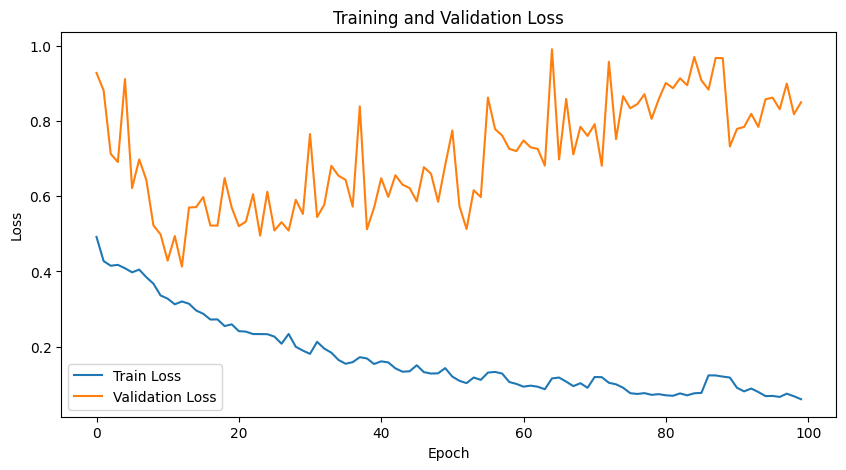

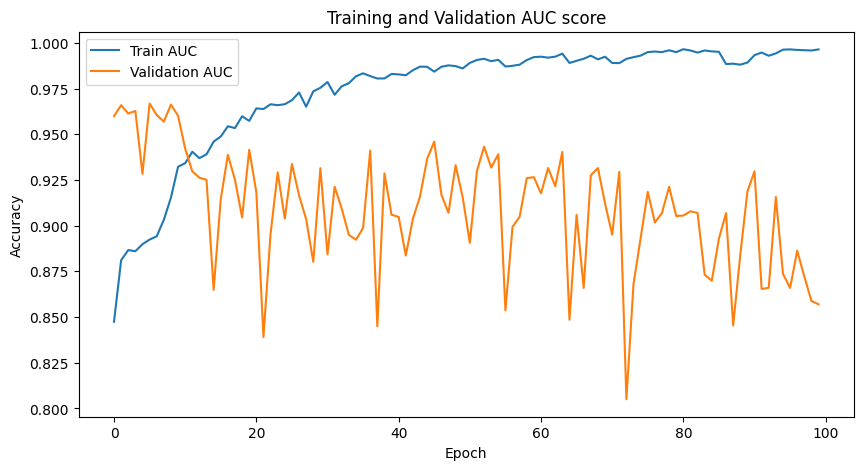

In [8]:
# 훈련 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig(f"plot/final_model_auc_{final_auc:.4f}_loss.png")  

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig(f"plot/final_model_auc_{final_auc:.4f}_auc.png")

In [9]:
# 모델 평가

# 테스트 데이터에 대한 예측 결과를 얻기 위해 모델 사용
predictions = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# 임계값 설정
threshold = 0.5  # 예측된 확률이 0.5 이상이면 클래스를 1로 예측

# 예측된 확률을 클래스 레이블로 변환
Y_pred_binary = (predictions >= threshold).astype(int)

# Precision 계산
precision = precision_score(Y_test, Y_pred_binary)

# Recall 계산
recall = recall_score(Y_test, Y_pred_binary)

# 테스트 데이터 
_, AUC = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), Y_test)

print("Precision:", precision)
print("Recall:", recall)
print(f'Model AUC: {AUC}')

5/5 [==============================] - 0s 7ms/step - loss: 3.3492 - auc: 0.6544
Precision: 0.5546875
Recall: 1.0
Model AUC: 0.6544193029403687


In [10]:
# 이동 평균을 계산하여 예측값 부드럽게 만들기
smoothed_predictions = np.convolve(predictions.squeeze(), np.ones(5)/5, mode='same')

# 테스트 데이터에 대한 예측 결과를 바이너리 형태로 변환
binary_predictions = (smoothed_predictions > 0.5).astype(int)

In [11]:
# 0에서 1로 바뀌는 구간에서 줄넘기 개수 카운트
jump_count = np.sum(np.diff(binary_predictions.flatten()) > 0)

In [12]:
# 테스트 데이터의 점프수
print(f'Predicted Jump Count: {jump_count}')


Predicted Jump Count: 2


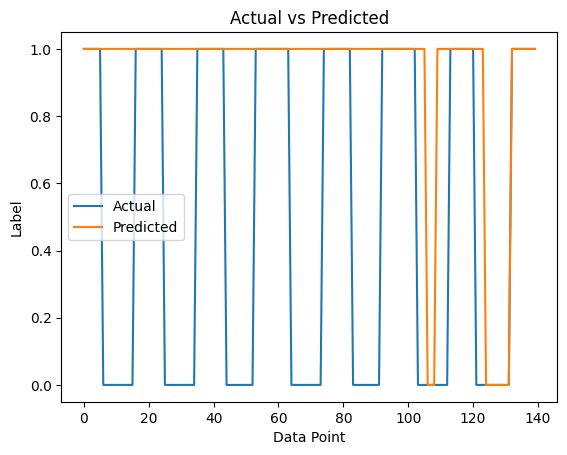

In [13]:
# 테스트 데이터 1에 대한 예측 결과

plt.plot(Y_test, label='Actual')
plt.plot(binary_predictions.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Data Point')
plt.ylabel('Label')
plt.legend()
plt.show()